<div class="alert alert-block alert-info">

# IMPLEMENTATION D'UN MODELE DE SCORING

> La société financière "Prêt à dépenser" propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. Elle souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifier la demande en crédit accordé ou refusé :
    <ul>
        <li>elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.),</li>
        <li>elle souhaite aussi développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.</li>
    </ul>

> L'objectif est donc de :
    <ul>
        <li>construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,</li>
        <li>construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client de ces gestionnaires ; ce dashboard remplira les fonctionnalités suivantes :</li>
            <ul>
                <li> visualisation du score et interprétation de ce score pour chaque client,</li>
                <li> visualisation des informations descriptives relatives à un client (via un système de filtre),</li>
                <li> comparaison des informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.</li>
            </ul>
    </ul>

> L'étude se décompose en différentes étapes :
    <ul>
        <li>une analyse exploratoire des données pour définir les données pertinentes,</li>
        <li>l'apprentissage de plusieurs méthodes de classification afin de sélectionner le plus optimal,</li>
            <ul>
                <li>méthode dummy,</li>
                <li>régression logistique,</li>
                <li>>arbre de décision,</li>
                <li>random forest,</li>
                <li><b>méthode extra tree,</b></li>
                <li>méthode XGB,</li>
                <li>méthode AdaBoost,</li>
                <li>méthode des k plus proches voisins,</li>
            </ul>
        <li>une synthèse sur la pertinence des variables pour le modèle de classification choisi.</li>
    </ul>

Les données sont fournies à l'adresse : 
https://www.kaggle.com/c/home-credit-default-risk/data - Projet+Mise+en+prod+-+home-credit-default-risk.zip

</div>

<div class="alert alert-block alert-info">

## 1. RECUPERATION DU DATASET

</div>

<div class="alert alert-block alert-info">
    
Chargement des packages Python pour le traitement des données.

</div>

In [1]:
# Importation des librairies
import os
import gc
import time
import datetime
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import numpy.random as nr

import scipy.stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
palette = sns.color_palette('Paired')
tab10 = sns.color_palette('tab10')
sns.set_context('paper', rc = {'font.size':12, 'figure.titlesize':18, 
                               'axes.titlesize':15, 'axes.labelsize':13, 
                               'xtick.labelsize': 13, 'ytick.labelsize': 13, 
                               'legend.fontsize': 9, 'legend.title_fontsize': 11}) 
import ipywidgets

# Faire apparaître les graphiques dans le notebook
%matplotlib inline

<div class="alert alert-block alert-info">
    
Chargement de la table des données.

</div>

In [2]:
# Jeux des données d'entraînement du fichier application 
data = pd.read_csv('donnees/transformees/data_train.csv', sep = ',')
print("Nettoyage des données du fichier application : ")
print("   - Nombre d'individus : ", data.shape[0])
print("   - Nombre de variables : ", data.shape[1])
data.head()

Nettoyage des données du fichier application : 
   - Nombre d'individus :  307488
   - Nombre de variables :  442


TARGET  DAYS_BIRTH  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0     1.0    0.881337         0.705433               1                0   
1     0.0    0.473087         0.959566               1                0   
2     0.0    0.345593         0.648326               1                1   
3     0.0    0.347884         0.661387               1                0   
4     0.0    0.296071         0.519522               1                0   

   FLAG_PHONE  FLAG_EMAIL  REG_REGION_NOT_LIVE_REGION  \
0           1           0                           0   
1           1           0                           0   
2           1           0                           0   
3           0           0                           0   
4           0           0                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  ...  \
0                           0                            0  ...   
1                           0                            0  ...   
2                           0                            0  ...   
3                           0                            0  ...   
4                           0                            0  ...   

   FONDKAPREMONT_MODE_org spec account  FONDKAPREMONT_MODE_reg oper account  \
0                                    0                                    1   
1                                    0                                    1   
2                                    0                                    1   
3                                    0                                    1   
4                                    0                                    1   

   FONDKAPREMONT_MODE_reg oper spec account  WALLSMATERIAL_MODE_Block  \
0                                         0                         0   
1                                         0                         1   
2                                         0                         0   
3                                         0                         0   
4                                         0                         0   

   WALLSMATERIAL_MODE_Mixed  WALLSMATERIAL_MODE_Monolithic  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   WALLSMATERIAL_MODE_Others  WALLSMATERIAL_MODE_Panel  \
0                          0                         0   
1                          0                         0   
2                          0                         1   
3                          0                         1   
4                          1                         0   

   WALLSMATERIAL_MODE_Stone, brick  WALLSMATERIAL_MODE_Wooden  
0                                1                          0  
1                                0                          0  
2                                0                          0  
3                                0                          0  
4                                0                          0  

[5 rows x 442 columns]

<div class="alert alert-block alert-info">

## 2. MODELES DE CLASSIFICATION

</div>

<div class="alert alert-block alert-info">

Séparation des variables prédictives et de la variable cible

</div>

In [3]:
# On sépare la variable cible que l'on souhaite prédire des varaibles prédictives.
y_target = 'TARGET'
X_columns = data.columns.drop(y_target)

<div class="alert alert-block alert-info">

### 2.1 Fonctions communes

</div>

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# Sélection des variables
def select_features(X1, y1, X2):
    # Sélection d'un sous-ensemble de variables
    fs = SelectFromModel(RandomForestClassifier(n_estimators=50, max_features='sqrt'))
    # Apprentissage des relations des données d'entraînement (X1, y1)
    fs.fit(X1, y1)
    # Transformation des données d'entraînement d'entrée
    X1_fs = fs.transform(X1)
    # Transformation des données de test d'entrée
    X2_fs = fs.transform(X2)
    # Noms des features sélectionnées 
    f_names = fs.get_feature_names_out(input_features=None)
    
    return X1_fs, X2_fs, f_names, fs

# Tracé des effectifs de la variable cible (apprentissage et test)
def target_feature_plot(X, Y):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    
    plt.suptitle('Effectifs de la variable cible par classe', fontsize=22)
    
    plt.subplot(121)
    X.sort_values().value_counts().plot(kind='bar', color=[palette[0], palette[1]], title='Données d\'apprentissage')
    classes = pd.Series(X.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.subplot(122)
    Y.sort_values().value_counts().plot(kind='bar', color=[palette[2], palette[3]], title='Données de test')
    classes = pd.Series(Y.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.tight_layout()

# Tracé des effectifs de la variable cible (par ré-équilibrage)
def classes_balancing_plot(X, Y, title):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(10, 5)
    
    plt.suptitle(title, fontsize=22)
    
    plt.subplot(121)
    X.sort_values().value_counts().plot(kind='bar', color=[palette[6], palette[7]], title='Données brutes')
    classes = pd.Series(X.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.subplot(122)
    Y.sort_values().value_counts().plot(kind='bar', color=[palette[8], palette[9]], title='Données ré-échantilonnées')
    classes = pd.Series(Y.sort_values().value_counts())
    for i in list(classes.index):
        plt.text(i-0.15, classes[i], str(classes[i]), color='black', verticalalignment='center', fontsize=15)
    
    plt.tight_layout()

# Evaluation des performances du modèle
def model_performance(y_true, y_pred, label):
    return pd.Series({'ROC-AUC' : roc_auc_score(y_true, y_pred),
                      'Fbeta': fbeta_score(y_true, y_pred, beta= 2),
                      'F1': f1_score(y_true, y_pred),
                      'Recall': recall_score(y_true, y_pred),
                      'Precision': precision_score(y_true, y_pred),
                      'Accuracy': accuracy_score(y_true, y_pred, normalize=True)
                     }, name=label)

# Tracé des métriques de la classification
def metrics_classification_plot(X):
    fig = plt.figure(figsize=(6,6))
    
    pos = list(range(len(X[X.columns[0]])))
    width = 0.4
    
    plt.title("Résultats des métriques de la classification", fontsize=22)
    plt.barh([p + 0.1 for p in pos], X[X.columns[0]], width, color=palette[0], label='Train')
    for i, v in enumerate(X[X.columns[0]]):
        plt.text(v, i + .25, str(round(v, 2)), color=palette[1], fontweight = 'bold', verticalalignment='top')
    plt.barh([p + 0.1 + width for p in pos], X[X.columns[1]], width, color=palette[2], label='Test')
    for i, v in enumerate(X[X.columns[1]]):
        plt.text(v, i + .25, str(round(v, 2)), color=palette[3], fontweight = 'bold', verticalalignment='bottom')
    plt.yticks([p + 0.3 for p in pos], X.index)
    plt.xlim(.0, 1.0)
    plt.legend(loc='best')
    
    plt.show()

# Matrice de confusion
def confusion_matrix_plot(y_true, y_pred):
    sns.set_context('talk')
    cm = confusion_matrix(y_true, y_pred)
    _, ax = plt.subplots(figsize=(8,6))

    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap=palette, annot_kws={"size": 14, "weight": "bold"})
    
    plt.suptitle('Matrice de confusion', fontsize=22)
    ax.set_xlabel('Valeurs prédictives', fontsize=16)
    ax.set_ylabel('Valeurs réelles', fontsize=16)
    ax.set_xticklabels(['Faux','Vrai'], fontsize=14)
    ax.set_yticklabels(['Faux','Vrai'], fontsize=14)
    
    plt.show()

# Tracé des courbes ROC-AUC et Précision/Rappel
def measure_performance_plot(y_test, y_prob):
    sns.set_context('talk')
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(12, 7)
    
    plt.suptitle('Courbes ROC-AUC and Precision-Recall', fontsize=22)

    # Plot the ROC-AUC curve
    ax = axList[0]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    # It is customary to draw a diagonal dotted line in ROC plots.
    # This is to indicate completely random prediction. Deviation from this dotted line towards 
    # the upper left corner signifies the power of the model.
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)
    
    # Plot the precision-recall curve
    ax = axList[1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', 
           ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    
    plt.tight_layout()

<div class="alert alert-block alert-info">

### 2.2 Extra Tree

</div>

<div class="alert alert-block alert-info">

#### 2.2.1 Extra Tree Classifier sur les données brutes

</div>

In [5]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Apprentissage du modèle 
def model_training(mdl, X, y):
    # Préparation des données d'apprentissage et de test
    #    - créer les data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
    #    - afficher la répartition de la variable cible 
    target_feature_plot(y_train, y_test)
    
    # Apprentissage du modèle
    mdl = mdl.fit(X_train, y_train)
    
    # Prédictions sur les data sets d'entraînement et de test
    y_train_predicted = mdl.predict(X_train)
    y_test_predicted = mdl.predict(X_test)
    y_test_probability = mdl.predict_proba(X_test)
    
    # Calcul des métriques
    m_clas = pd.concat([model_performance(y_train, y_train_predicted, 'MDL_Train'),
                        model_performance(y_test, y_test_predicted, 'MDL_Test')
                       ], axis=1)
    
    # Affichage des différentes métriques
    metrics_classification_plot(m_clas)
    confusion_matrix_plot(y_test, y_test_predicted)
    measure_performance_plot(y_test, y_test_probability)
    
    return mdl, X_train, y_train, X_test, y_test,\
           y_train_predicted, y_test_predicted, y_test_probability,\
           X_columns, m_clas

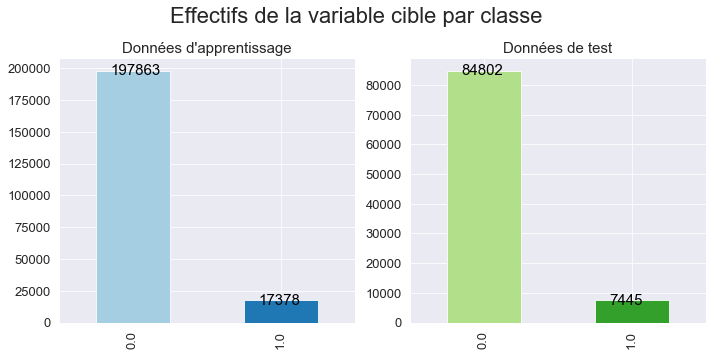

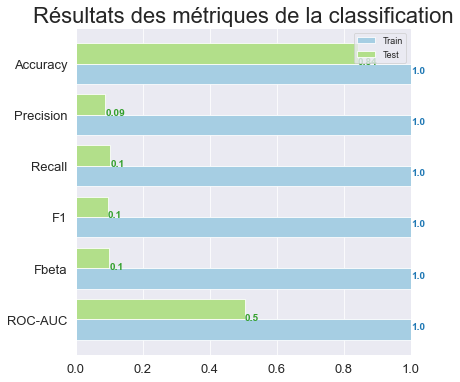

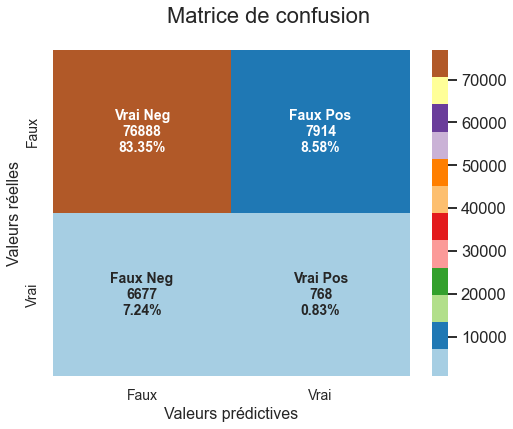


Temps d'exécution de l'apprentissage : 0:00:05.851397


15248

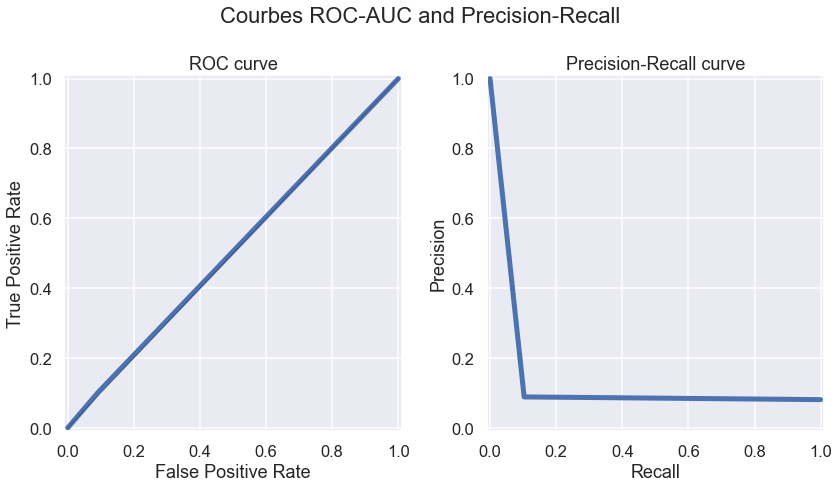

In [6]:
start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42)

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X, y)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

#### 2.2.2 Extra Tree Classifier : rééquilibrage des classes

</div>

<div class="alert alert-block alert-info">

##### 2.2.2.1 Sous-échantillonage aléatoire manuel

</div>

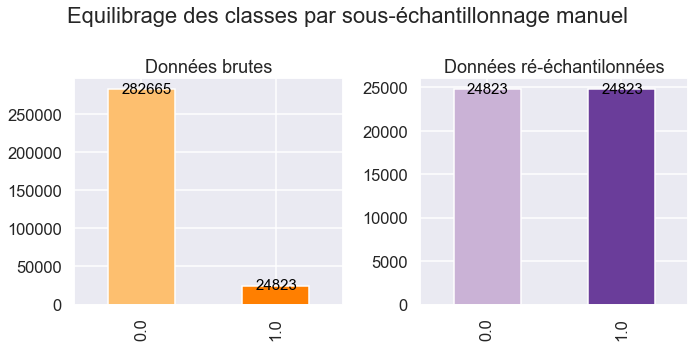

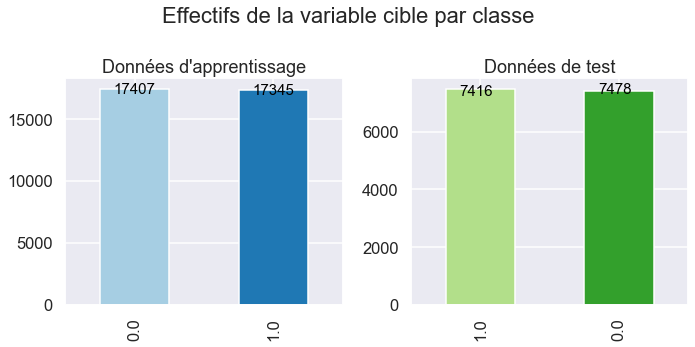

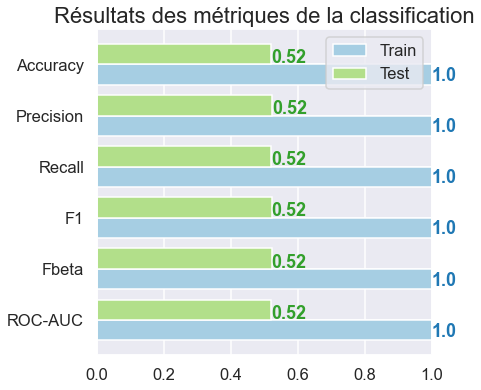

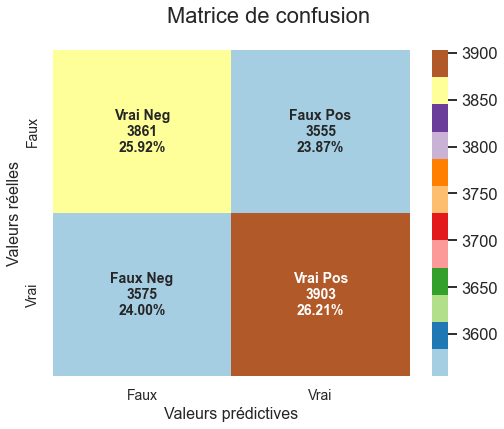


Temps d'exécution de l'apprentissage : 0:00:02.432740


26310

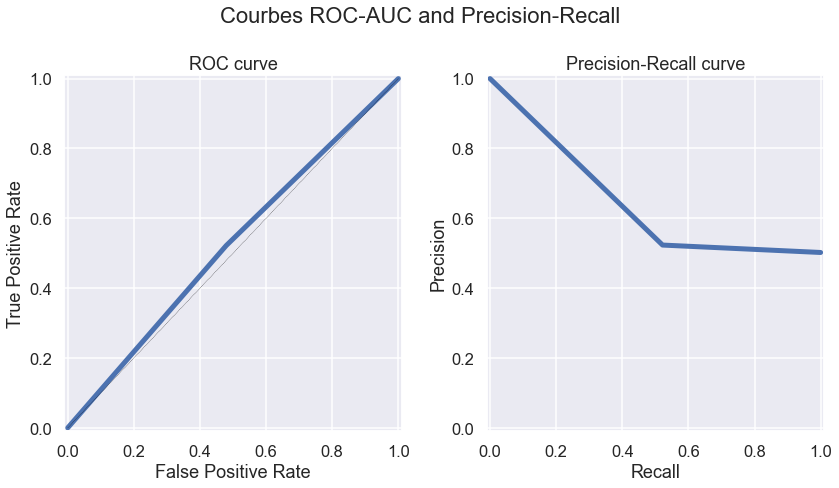

In [7]:
# La technique consiste à supprimer aléatoirement les enregistrements de la classe majoritaire (ce qui peut 
# entraîner une perte d’information).

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42)

# Séparation des variables predictives et de la variable cible
target_0 = data[data[y_target] == 0]
target_1 = data[data[y_target] == 1]

# Comptage des effectifs de chaque classe
target_count_0, target_count_1 = data[y_target].value_counts()

# Rééquilibrage des classes
target_0_under = target_0.sample(target_count_1)
target_under = pd.concat([target_0_under, target_1], axis=0)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sous-échantillonnage manuel'
classes_balancing_plot(y, target_under[y_target], titre)

# Le sous-échantillonnage peut être défini comme la suppression de certaines observations de la classe majoritaire. 
# Cela se fait jusqu’à ce que la classe majoritaire et la classe minoritaire soient équilibrées.
# Le sous-échantillonnage peut être un bon choix lorsque vous avez une tonne de données (millions de lignes). 
# Mais un inconvénient du sous-échantillonnage est que nous supprimons les informations qui peuvent être précieuses.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, target_under[X_columns], target_under[y_target])

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.2 Sur-échantillonage aléatoire manuel

</div>

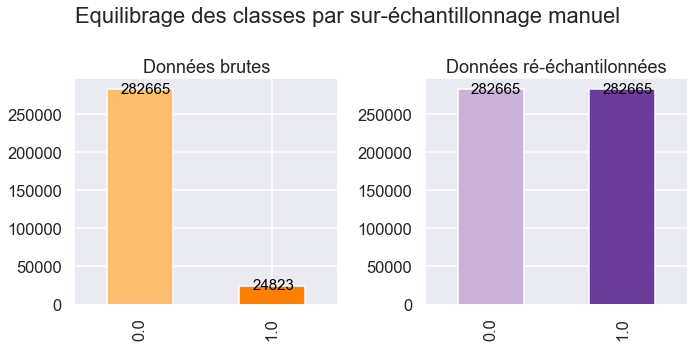

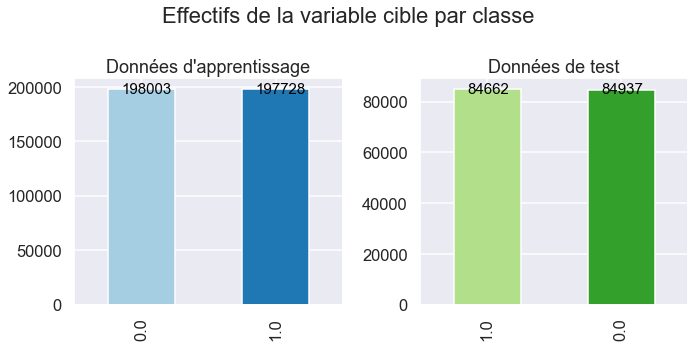

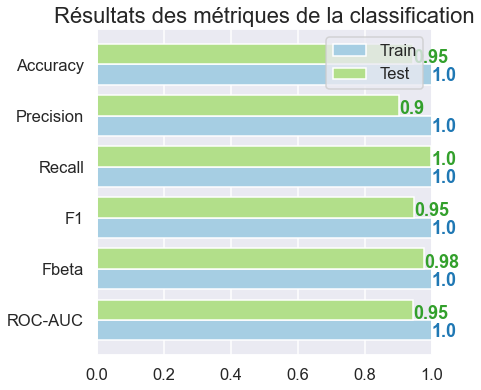

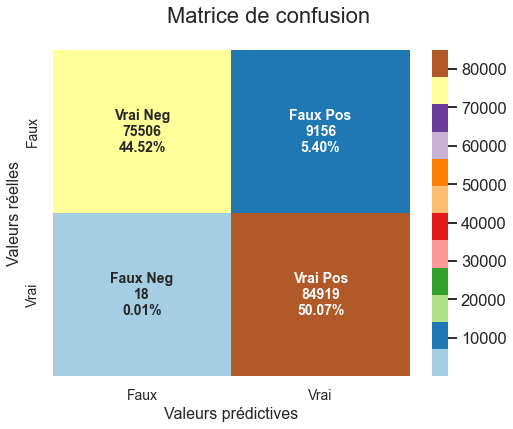


Temps d'exécution de l'apprentissage : 0:00:13.241401


25998

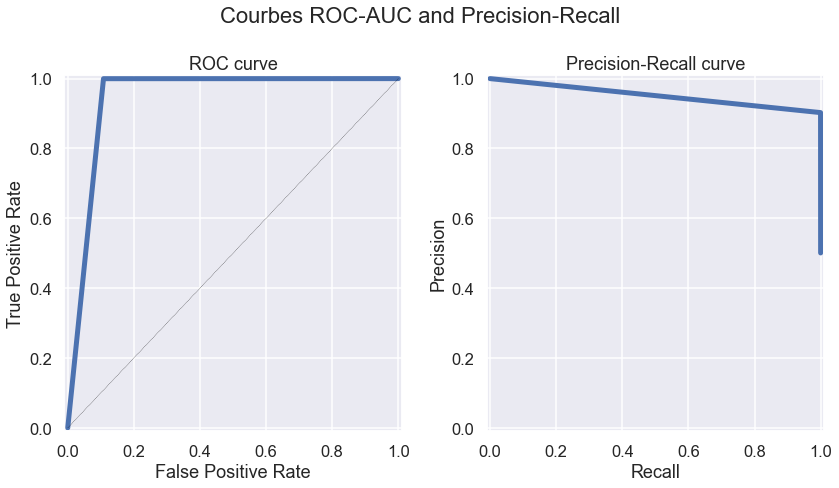

In [8]:
# La mise en œuvre du suréchantillonnage consiste à dupliquer les enregistrements aléatoires de la classe minoritaire 
#(ce qui peut entraîner une surpêche).

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42)

# Séparation des variables predictives et de la variable cible
target_0 = data[data[y_target] == 0]
target_1 = data[data[y_target] == 1]

# Comptage des effectifs de chaque classe
target_count_0, target_count_1 = data[y_target].value_counts()

# Rééquilibrage des classes
target_1_over = target_1.sample(target_count_0, replace=True)
target_over = pd.concat([target_1_over, target_0], axis=0)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage manuel'
classes_balancing_plot(y, target_over[y_target], titre)

# Le suréchantillonnage peut être défini comme l’ajout de copies supplémentaires à la classe minoritaire. 
#Le suréchantillonnage peut être un bon choix lorsque vous n’avez pas une tonne de données avec lesquelles travailler.
# Un inconvénient à considérer lors du sous-échantillonnage est qu’il peut entraîner un surajustement et 
# une mauvaise généralisation de votre ensemble de test.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, target_over[X_columns], target_over[y_target])

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.3 Sous-échantillonage aléatoire avec imbalanced_learn

</div>

In [9]:
# Un certain nombre de techniques de rééchantillonnage plus sophistiquées ont été proposées dans la littérature 
# scientifique. Par exemple, nous pouvons regrouper les enregistrements de la classe majoritaire et effectuer 
# le sous-échantillonnage en supprimant les enregistrements de chaque groupe, cherchant ainsi à préserver l’information.
# Dans le suréchantillonnage, au lieu de créer des copies exactes des enregistrements de classe minoritaire, 
# nous pouvons introduire de petites variations dans ces copies, créant ainsi des échantillons synthétiques 
# plus diversifiés.

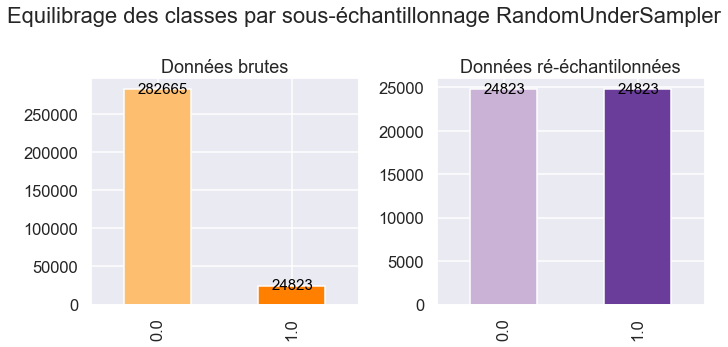

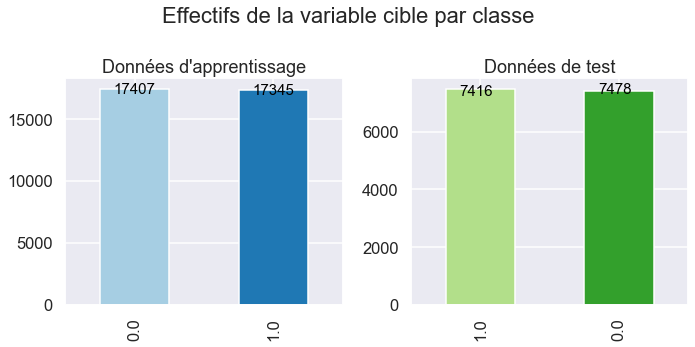

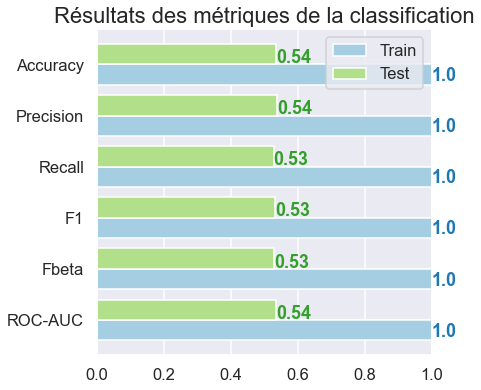

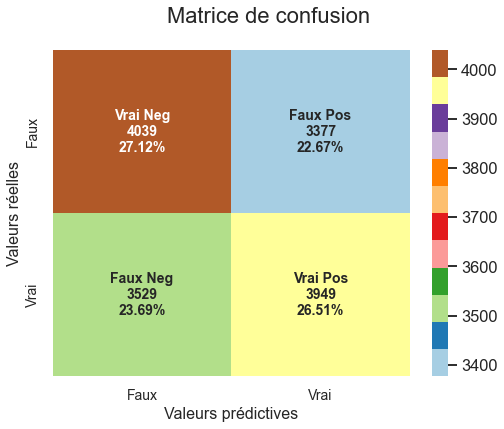


Temps d'exécution de l'apprentissage : 0:00:03.300035


26334

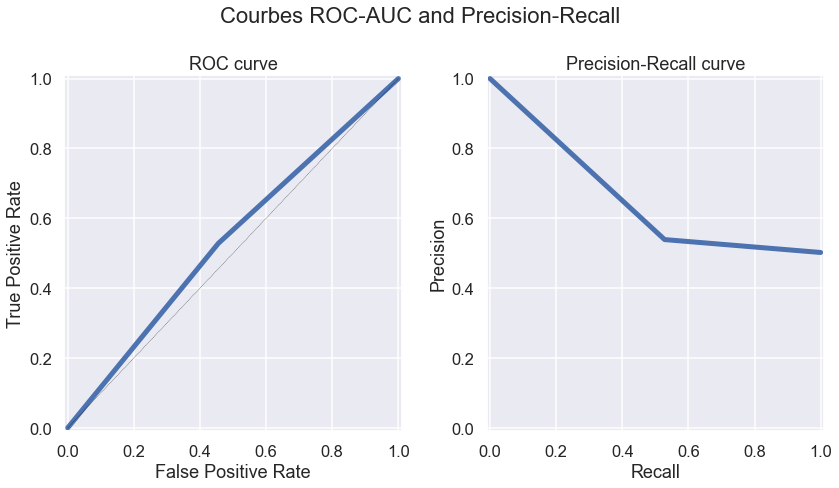

In [10]:
from imblearn.under_sampling import RandomUnderSampler

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42) 

# Séparation des variables predictives et de la variable cible
target_0 = data[data[y_target] == 0]
target_1 = data[data[y_target] == 1]

# Rééquilibrage des classes
rus = RandomUnderSampler(random_state=42, replacement=True)
X_rus, y_rus = rus.fit_resample(X, y)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sous-échantillonnage RandomUnderSampler'
classes_balancing_plot(y, y_rus, titre)

# RandomUnderSampler permet de sous-échantillonner la classe majoritaire en prélevant au hasard des échantillons 
# avec ou sans remplacement.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X_rus, y_rus)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.4 Sur-échantillonage aléatoire avec imbalanced_learn

</div>

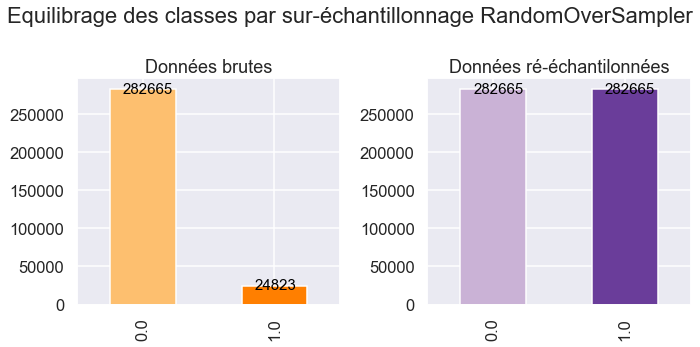

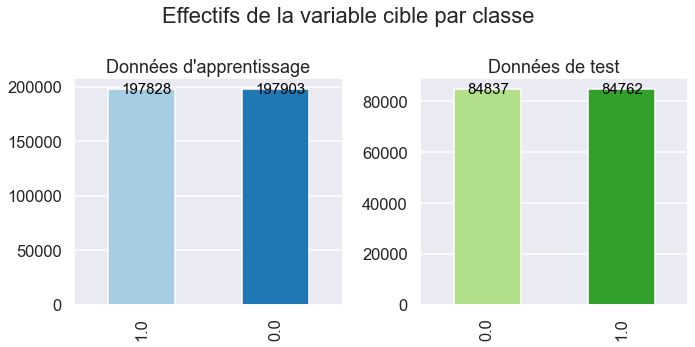

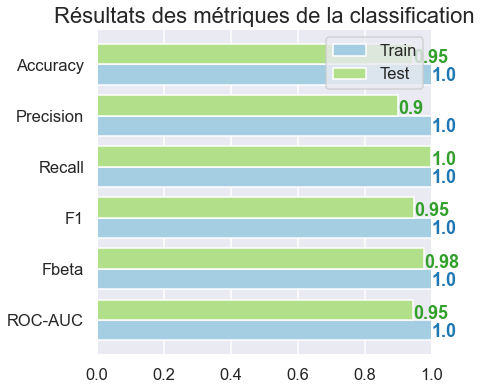

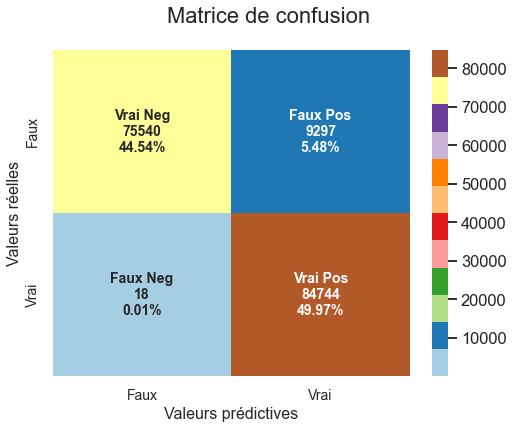


Temps d'exécution de l'apprentissage : 0:00:19.815826


26134

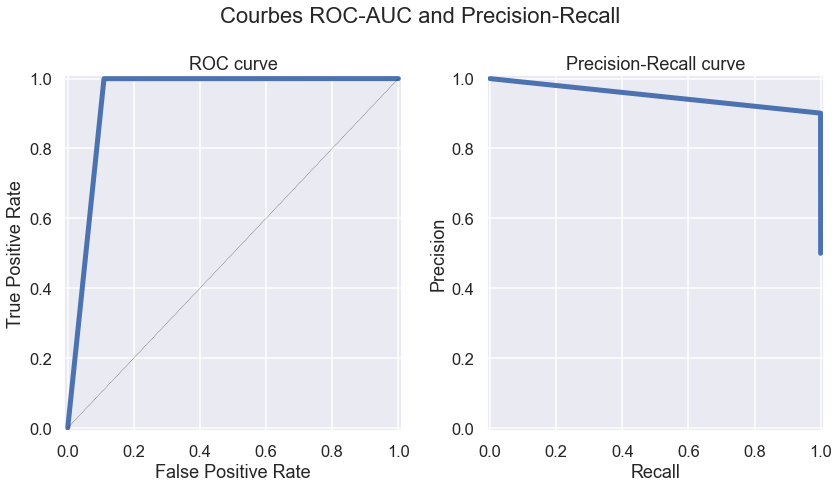

In [11]:
from imblearn.over_sampling import RandomOverSampler

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42) 

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Rééquilibrage des classes
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage RandomOverSampler'
classes_balancing_plot(y, y_ros, titre)

# RandomOverSampler permet de générer de nouveaux échantillons dans les classes minoritaires. 
# La stratégie la plus naïve consiste à générer de nouveaux échantillons par échantillonnage aléatoire 
# en remplacement des échantillons actuellement disponibles.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X_ros, y_ros)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.5 Echantillonage avec Tomeklinks

</div>

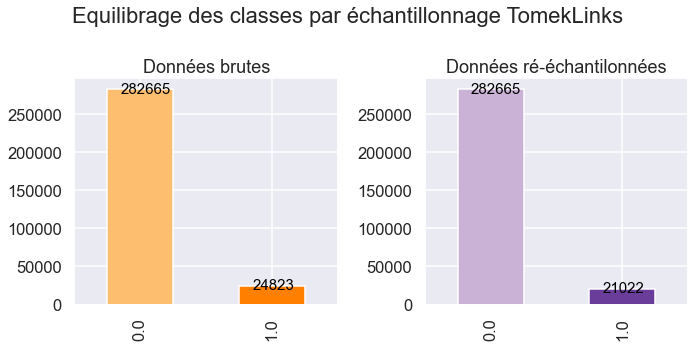

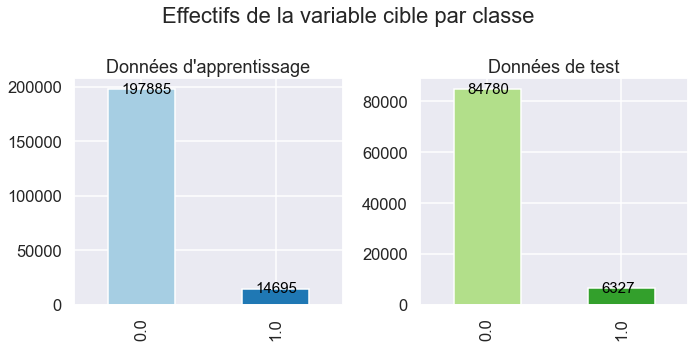

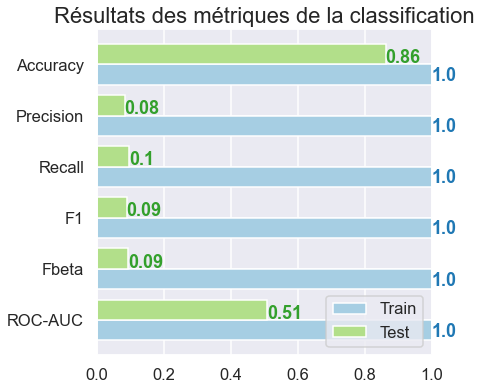

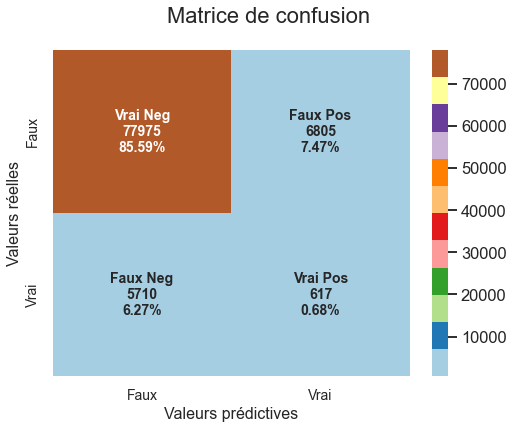


Temps d'exécution de l'apprentissage : 1:05:48.601235


26046

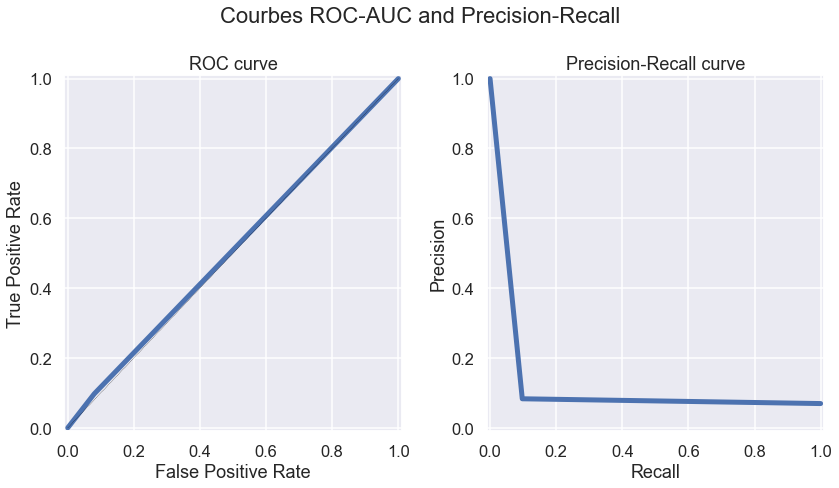

In [12]:
from imblearn.under_sampling import TomekLinks

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42) 

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Rééquilibrage des classes
tl = TomekLinks(sampling_strategy='not majority')
X_tl, y_tl = tl.fit_resample(X, y)

# Tracé du rééquilibrage des classes après échantillonnage
titre = 'Equilibrage des classes par échantillonnage TomekLinks'
classes_balancing_plot(y, y_tl, titre)

# Les liens Tomek sont des paires d’instances très proches mais de classes opposées. 
# La suppression des instances de la classe majoritaire de chaque paire augmente l’espace entre les deux classes, 
# ce qui facilite le processus de classification.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X_tl, y_tl)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.6 Echantillonage avec SMOTE

</div>

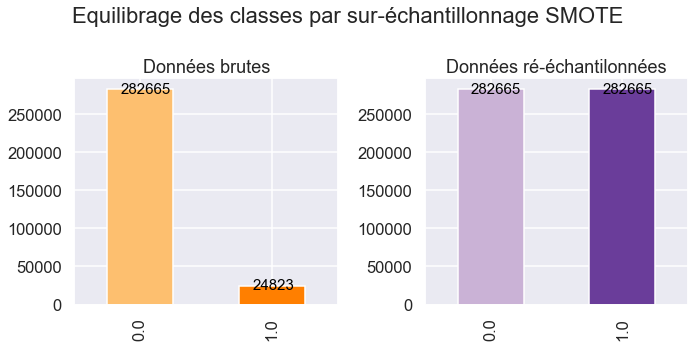

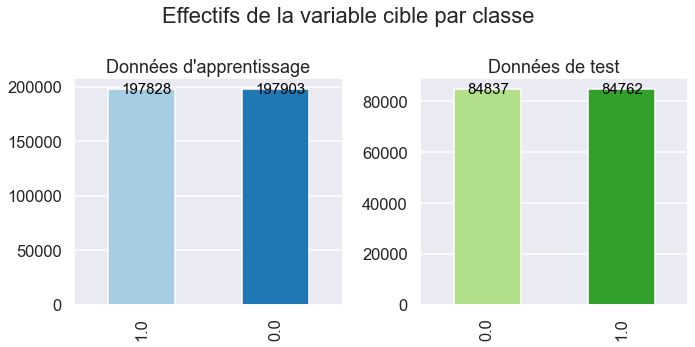

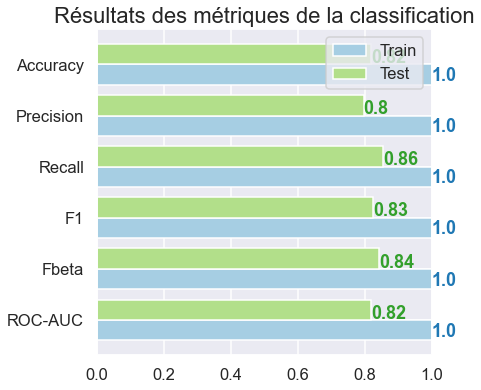

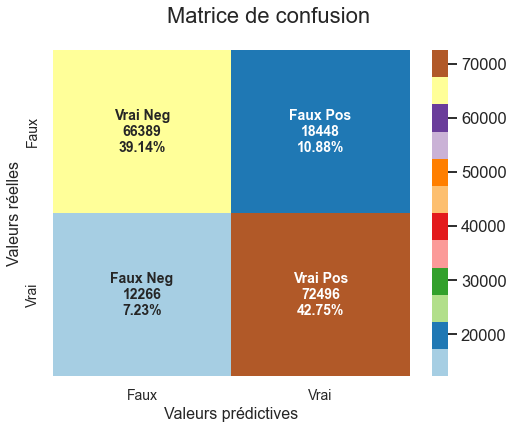


Temps d'exécution de l'apprentissage : 0:00:27.216884


25850

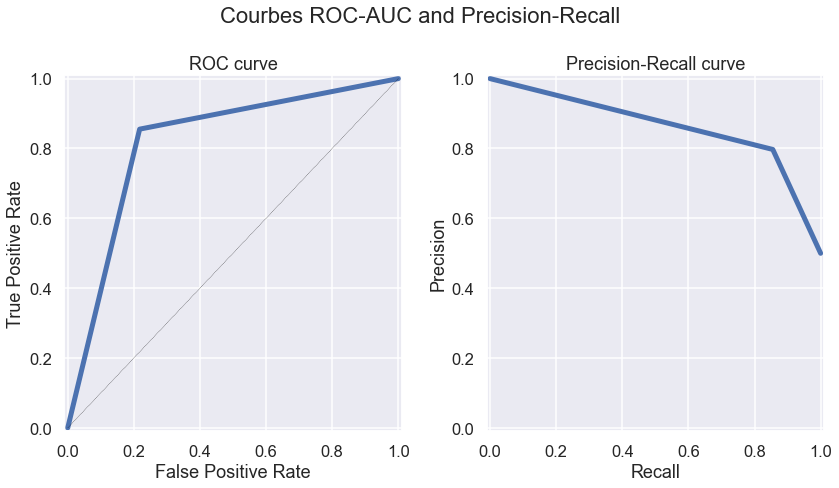

In [13]:
from imblearn.over_sampling import SMOTE

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42)

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Rééquilibrage des classes
smote = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage SMOTE'
classes_balancing_plot(y, y_smote, titre)

# Cette technique génère des données synthétiques pour la classe minoritaire. 
# SMOTE (Synthetic Minority Oversampling Technique) fonctionne en choisissant au hasard un point de la classe 
# minoritaire et en calculant les k-voisins les plus proches pour ce point. 
# Les points synthétiques sont ajoutés entre le point choisi et ses voisins.
# L’algorithme SMOTE fonctionne en 4 étapes simples :
# 1- Choisissez une classe minoritaire comme vecteur d’entrée
# 2- Trouver ses k voisins les plus proches (k_neighbors est spécifié comme argument dans la fonction SMOTE())
# 3- Choisissez l’un de ces voisins et placez un point synthétique n’importe où sur la ligne reliant 
#    le point considéré et son voisin choisi
# 4- Répétez les étapes jusqu’à ce que les données soient équilibrées

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X_smote, y_smote)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.2.7 Echantillonage avec NearMiss

</div>

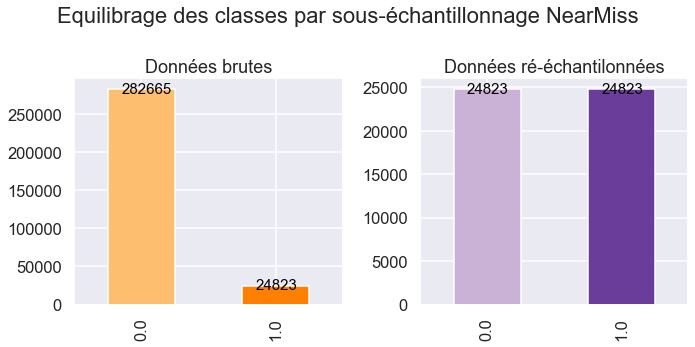

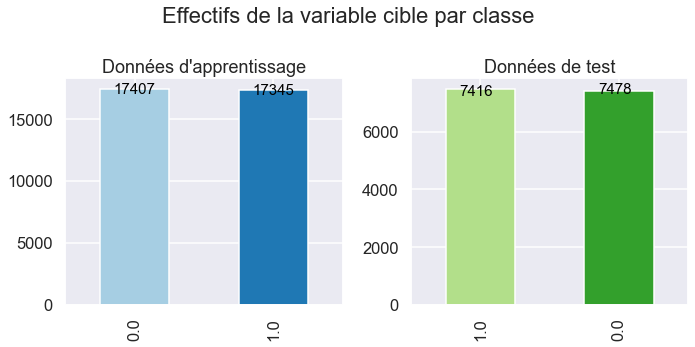

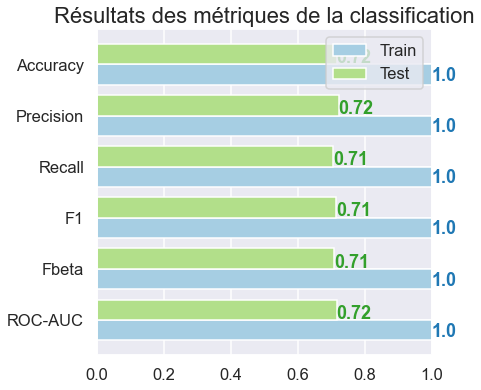

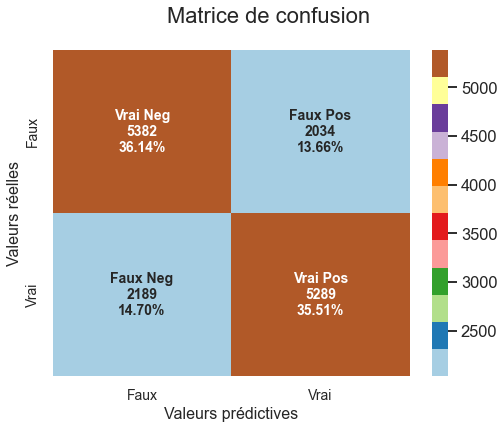


Temps d'exécution de l'apprentissage : 0:02:17.646286


26247

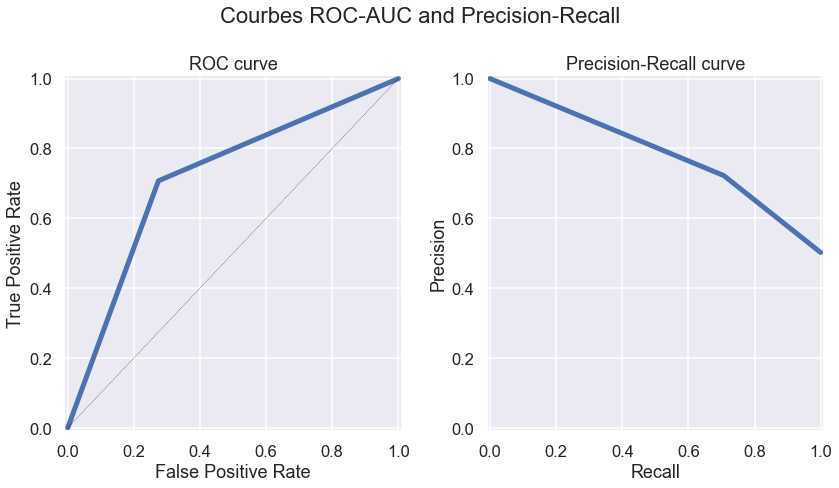

In [14]:
from imblearn.under_sampling import NearMiss

start = time.time()

# Initialisation du modèle
et = ExtraTreeClassifier(random_state=42)

# Séparation des variables predictives et de la variable cible
X = data[X_columns]
y = data[y_target]

# Rééquilibrage des classes
nm = NearMiss(sampling_strategy='majority', n_neighbors=3)
X_nm, y_nm = nm.fit_resample(X, y)

# Tracé du rééquilibrage des classes après sur-échantillonnage
titre = 'Equilibrage des classes par sous-échantillonnage NearMiss'
classes_balancing_plot(y, y_nm, titre)

# NearMiss est une technique de sous-échantillonnage. Au lieu de rééchantillonner la classe minoritaire, 
# en utilisant une distance, cela rendra la classe majoritaire égale à la classe minoritaire.

# Apprentissage du modèle
et, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names, clas_scores = \
                      model_training(et, X_nm, y_nm)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del et
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

#### 2.2.3 Extra Tree Classifier : optimisation avec hyperparamètres 

</div>

<div class="alert alert-block alert-info">

Les méthodes de sur-échantillonnage, à l'exception de NearMiss, ont donné les meilleurs scores AUC, avec les paramètres par défaut de RandomForest. Il semblerait cependant que ces scores élevés soient le résultat de sur-apprentissage sur les données fournies, ce qui semble moins le cas avec l'échantillonnage NearMiss.<br>
En utilisant maintenant la fonction GrisSearchCV, nous allons optimiser les hyperparamètres pour essayer d'améliorer ce score avec la méthode SMOTE. 

</div>

<div class="alert alert-block alert-info">

##### 2.2.3.1 Optimisation avec un échantillonnage SMOTE

</div>


Meilleur coefficient ROC_AUC : 0.8658025102552886  obtenu pour le(s) hyperparamètre(s) : {'criterion': 'entropy', 'max_features': None}


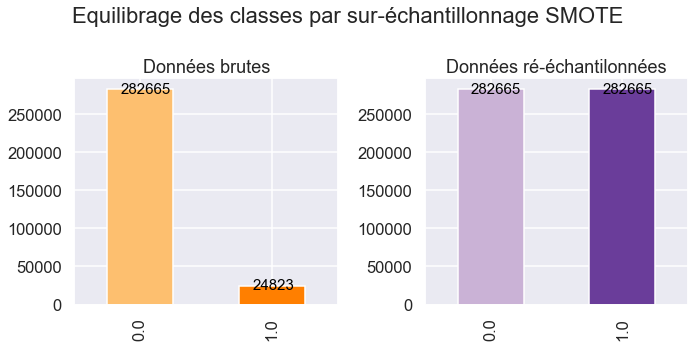

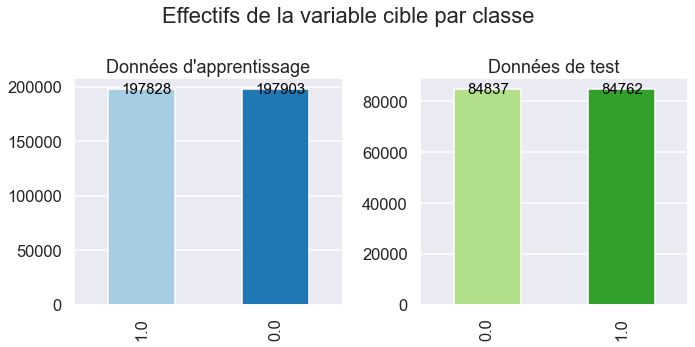

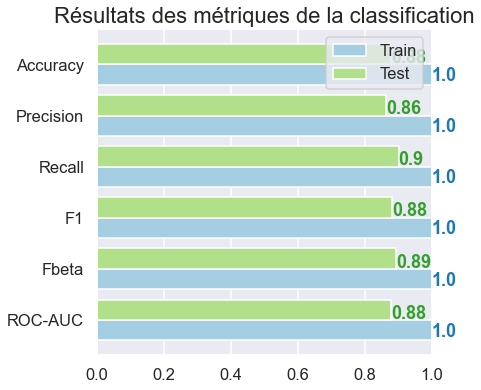

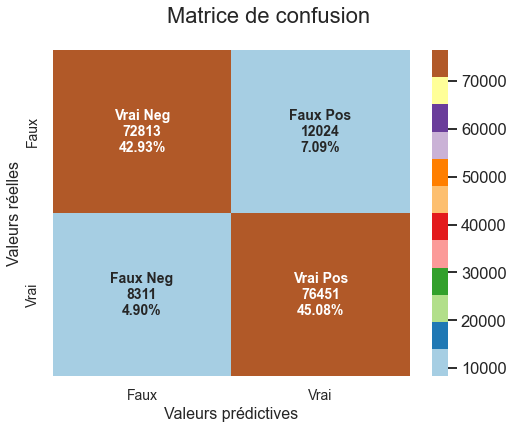


Temps d'exécution de l'apprentissage : 0:01:47.604192


25906

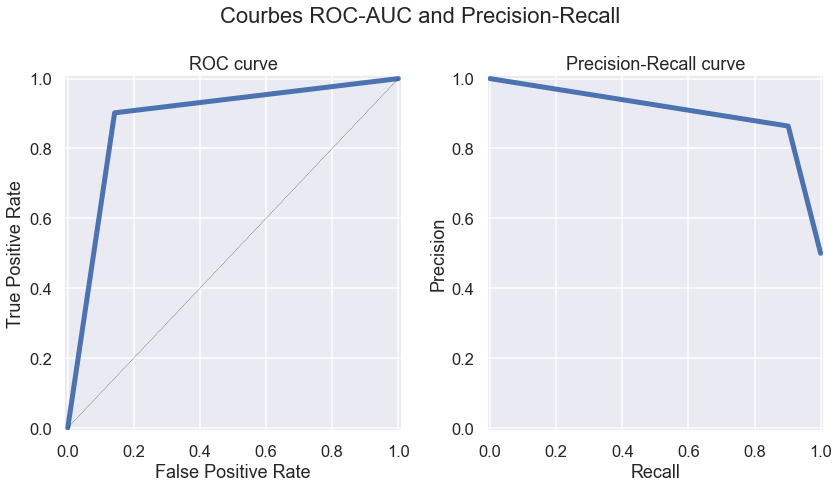

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

start = time.time()

# Tracé du rééquilibrage des classes après échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage SMOTE'
classes_balancing_plot(y, y_smote, titre)

# Initialisation du modèle
kf = KFold(n_splits=4, shuffle=True, random_state=72)
et = ExtraTreeClassifier(random_state=42)

# Définition d'un pipeline avec la méthode de classification
#estimator = Pipeline([("extratree", et)])

# Paramètres de la méthode de classification 
params = {'max_features': ['auto', 'sqrt', 'log2', None],
          'criterion': ['gini', 'log_loss', 'entropy']
         }

# Instanciation de la méthode de validation croisées 4-Fold
ET_grid = GridSearchCV(et, params, cv=kf, scoring = 'roc_auc', n_jobs=-1)

# Préparation des données d'apprentissage et de test
#    - créer les data sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=47)
#    - afficher la répartition de la variable cible 
target_feature_plot(y_train, y_test)

# Apprentissage du modèle
ET_grid = ET_grid.fit(X_train, y_train)

# Affichage du meilleur coefficient AUC et des hyper-paramètres qui y conduisent 
print("\nMeilleur coefficient ROC_AUC :", ET_grid.best_score_, 
      " obtenu pour le(s) hyperparamètre(s) :", ET_grid.best_params_)

# Prédictions sur les data sets d'entraînement et de test
y_train_pred = ET_grid.predict(X_train)
y_test_pred = ET_grid.predict(X_test)
y_test_prob = ET_grid.predict_proba(X_test)

# Calcul des métriques
clas_scores = pd.concat([model_performance(y_train, y_train_pred, 'ET_Train'),
                         model_performance(y_test, y_test_pred, 'ET_Test')
                        ], axis=1)

# Affichage des différentes métriques
metrics_classification_plot(clas_scores)
confusion_matrix_plot(y_test, y_test_pred)
measure_performance_plot(y_test, y_test_prob)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del ET_grid
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.3.2 Optimisation avec un échantillonage SMOTE avec sélection de variables

</div>


Meilleur coefficient ROC_AUC : 0.8080089999245621  obtenu pour le(s) hyperparamètre(s) : {'criterion': 'entropy', 'max_features': None}


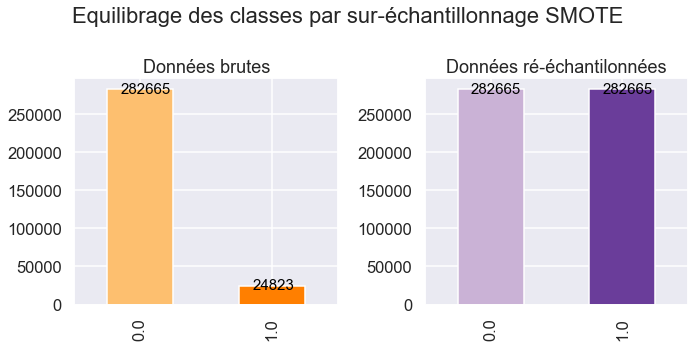

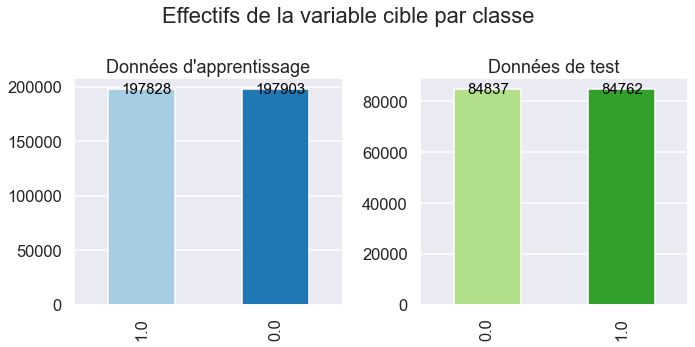

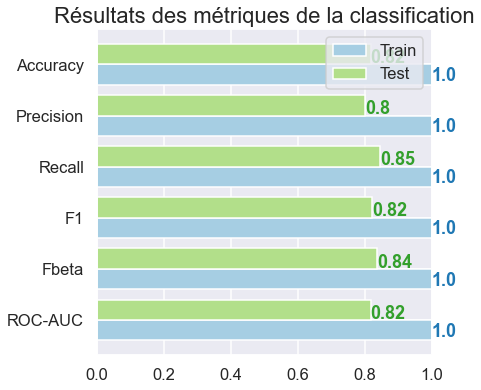

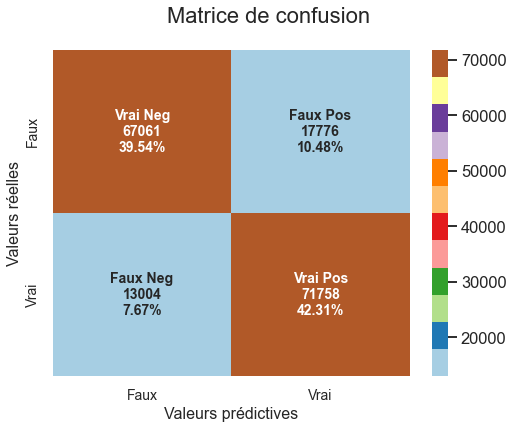


Temps d'exécution de l'apprentissage : 0:06:47.964109


25859

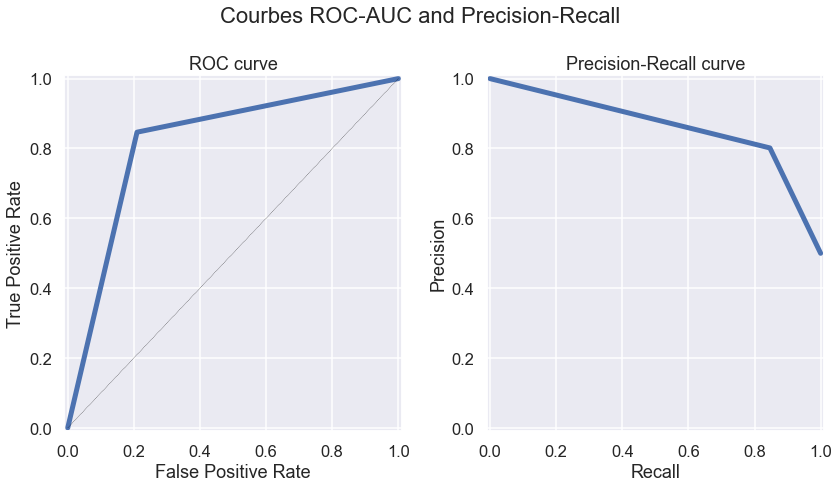

In [17]:
start = time.time()

# Tracé du rééquilibrage des classes après échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage SMOTE'
classes_balancing_plot(y, y_smote, titre)

# Initialisation du modèle
kf = KFold(n_splits=4, shuffle=True, random_state=72)
et = ExtraTreeClassifier(random_state=42)

# Définition d'un pipeline avec la méthode de classification
#estimator = Pipeline([("extratree", et)])

# Paramètres de la méthode de classification 
params = {'max_features': ['auto', 'sqrt', 'log2', None],
          'criterion': ['gini', 'log_loss', 'entropy']
         }

# Instanciation de la méthode de validation croisées 4-Fold
ET_grid = GridSearchCV(et, params, cv=kf, scoring = 'roc_auc', n_jobs=-1)

# Préparation des données d'apprentissage et de test
#    - créer les data sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=47)
#    - afficher la répartition de la variable cible 
target_feature_plot(y_train, y_test)
#    - sélection des variables
X_train_fs, X_test_fs, feature_names, fs = select_features(X_train, y_train, X_test)

# Apprentissage du modèle
ET_grid = ET_grid.fit(X_train_fs, y_train)

# Affichage du meilleur coefficient AUC et des hyper-paramètres qui y conduisent 
print("\nMeilleur coefficient ROC_AUC :", ET_grid.best_score_, 
      " obtenu pour le(s) hyperparamètre(s) :", ET_grid.best_params_)

# Prédictions sur les data sets d'entraînement et de test
y_train_pred = ET_grid.predict(X_train_fs)
y_test_pred = ET_grid.predict(X_test_fs)
y_test_prob = ET_grid.predict_proba(X_test_fs)

# Calcul des métriques
clas_scores = pd.concat([model_performance(y_train, y_train_pred, 'ET_Train'),
                         model_performance(y_test, y_test_pred, 'ET_Test')
                        ], axis=1)

# Affichage des différentes métriques
metrics_classification_plot(clas_scores)
confusion_matrix_plot(y_test, y_test_pred)
measure_performance_plot(y_test, y_test_prob)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

del ET_grid
del X_train, X_train_fs, y_train, X_test, X_test_fs, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.3.3 Modèlisation avec les hyperparamètres optimaux

</div>

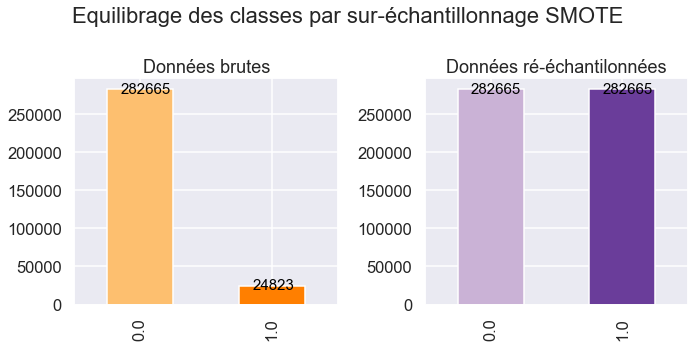

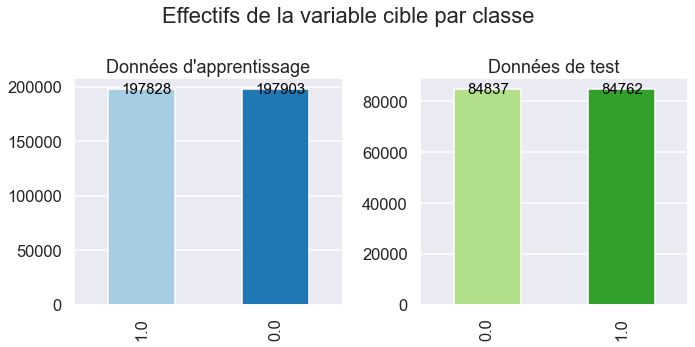

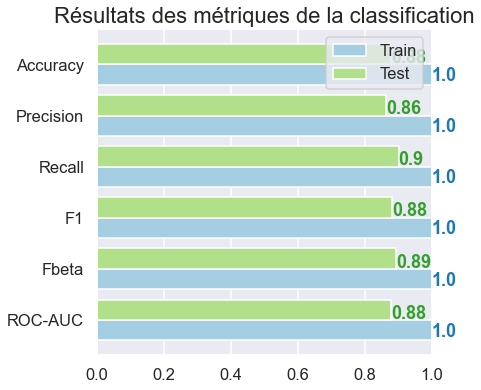

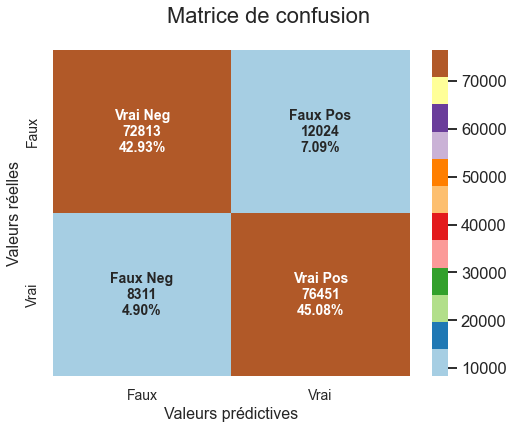


Temps d'exécution de l'apprentissage : 0:00:28.809720


25921

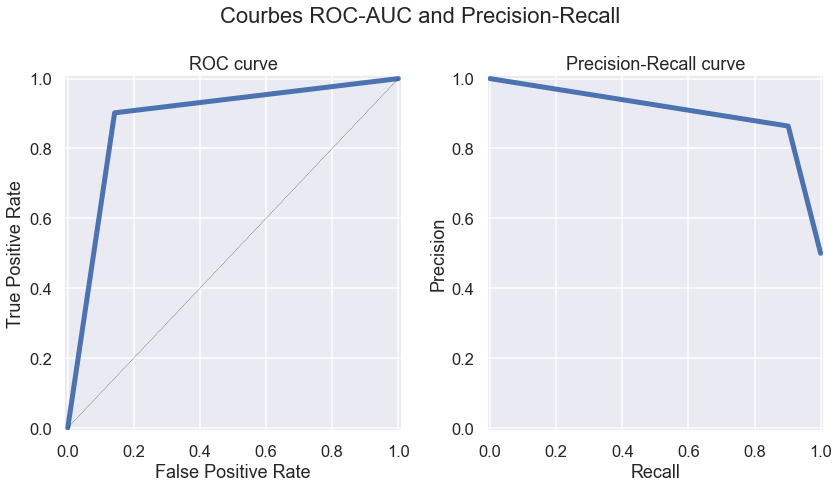

In [18]:
start = time.time()

# Tracé du rééquilibrage des classes après échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage SMOTE'
classes_balancing_plot(y, y_smote, titre)

# Initialisation du modèle
et_1 = ExtraTreeClassifier(criterion='entropy', max_features=None, random_state = 42)

# Apprentissage du modèle
et_1, X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_test_prob, f_names_1, clas_scores_1 = \
                      model_training(et_1, X_smote, y_smote)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

#del et_1
del X_train, y_train, X_test, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.3.4 Modèlisation avec les hyperparamètres optimaux et sélection de variables

</div>

In [19]:
# Apprentissage du modèle 
def model_training_sfm(mdl, X, y):
    # Préparation des données d'apprentissage et de test
    #    - créer les data sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
    #    - afficher la répartition de la variable cible 
    target_feature_plot(y_train, y_test)
    #    - sélection des variables
    X_train_fs, X_test_fs, feature_names, fs = select_features(X_train, y_train, X_test)
    
    # Apprentissage du modèle
    mdl = mdl.fit(X_train_fs, y_train)
    
    # Prédictions sur les data sets d'entraînement et de test
    y_train_predicted = mdl.predict(X_train_fs)
    y_test_predicted = mdl.predict(X_test_fs)
    y_test_probability = mdl.predict_proba(X_test_fs)
    
    # Calcul des métriques
    m_clas = pd.concat([model_performance(y_train, y_train_predicted, 'MDL_Train'),
                        model_performance(y_test, y_test_predicted, 'MDL_Test')
                       ], axis=1)
    
    # Affichage des différentes métriques
    metrics_classification_plot(m_clas)
    confusion_matrix_plot(y_test, y_test_predicted)
    measure_performance_plot(y_test, y_test_probability)
    
    return mdl, X_train_fs, y_train, X_test_fs, y_test,\
           y_train_predicted, y_test_predicted, y_test_probability,\
           feature_names, m_clas

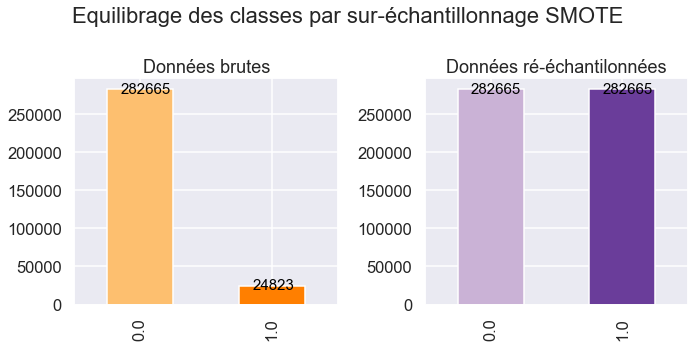

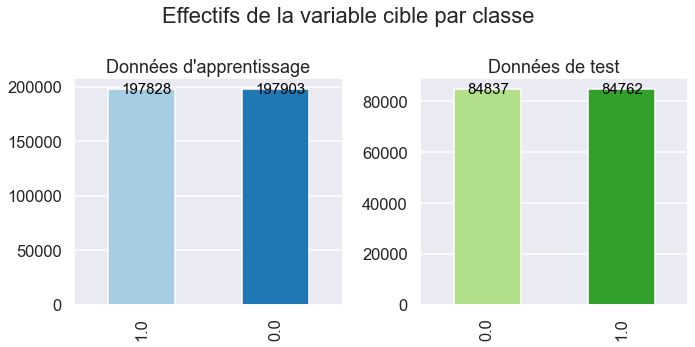

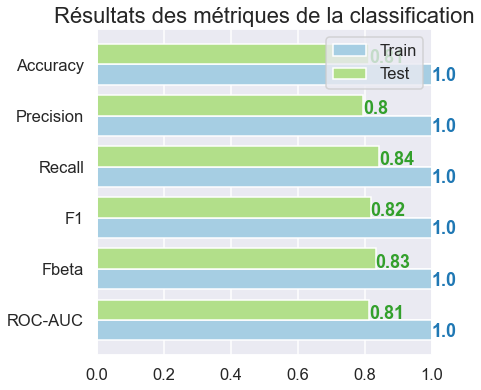

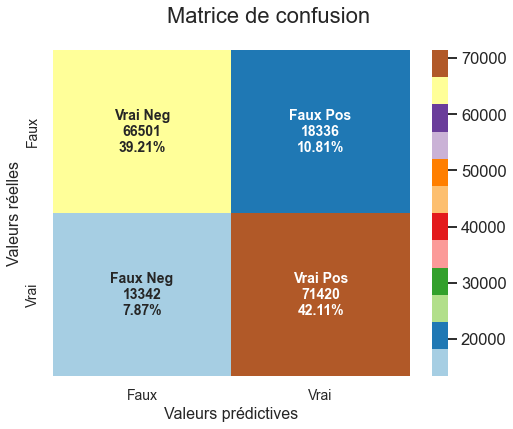


Temps d'exécution de l'apprentissage : 0:06:24.767364


25849

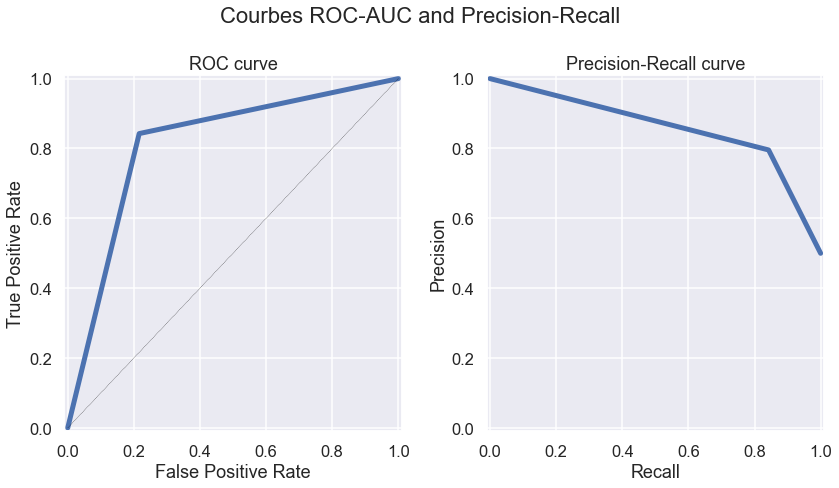

In [20]:
start = time.time()

# Tracé du rééquilibrage des classes après échantillonnage
titre = 'Equilibrage des classes par sur-échantillonnage SMOTE'
classes_balancing_plot(y, y_smote, titre)

# Initialisation du modèle
et_2 = ExtraTreeClassifier(criterion='entropy', max_features=None, random_state = 42)

# Apprentissage du modèle
et_2, X_train_fs, y_train, X_test_fs, y_test, y_train_pred, y_test_pred, y_test_prob, f_names_2, clas_scores_2 = \
                         model_training_sfm(et_2, X_smote, y_smote)

end = time.time()
print("\nTemps d'exécution de l'apprentissage : {}".format(datetime.timedelta(seconds = (end-start))))

#del et_2
del X_train_fs, y_train, X_test_fs, y_test
del y_train_pred, y_test_pred, y_test_prob
gc.collect()

<div class="alert alert-block alert-info">

##### 2.2.3.5 Performances des variables

</div>

In [21]:
if clas_scores_1['MDL_Test']['ROC-AUC'] >= clas_scores_2['MDL_Test']['ROC-AUC']:
    et = et_1
    f_names = f_names_1
else:
    et = et_2
    f_names = f_names_2

<div class="alert alert-block alert-info">
    
Importances globales des variables.

</div>

In [22]:
# Tracé des features selon leur importance dans l'apprentissage (classification binaire)
def feature_importances_plot(feature_names, features, feature_count):
    sns.set_context('talk')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)
       
    f_imp_df = pd.DataFrame(features, feature_names, columns = ['Importance'])
    
    plt.suptitle('Feature importances', fontsize=22)
    # Plot the negative scores.
    f_imp_df_c0 = f_imp_df.sort_values(by=['Importance'], ascending=True)[:feature_count]
    if f_imp_df_c0['Importance'].min() < 0.:
        ax1.barh(f_imp_df_c0.index, f_imp_df_c0['Importance'], color=palette[5])
        ax1.yaxis.tick_left()
        ax1.set_yticklabels(f_imp_df_c0.index, fontsize=10)
    ax1.set_title('Negative importance')
    # Plot the positive scores.
    f_imp_df_c1 = f_imp_df.sort_values(by=['Importance'], ascending=False)[:feature_count]
    if f_imp_df_c1['Importance'].max() > 0.:
        ax2.barh(f_imp_df_c1.index, f_imp_df_c1['Importance'], color=palette[3])
        ax2.yaxis.tick_right()
        ax2.set_yticklabels(f_imp_df_c1.index, fontsize=10)
    ax2.set_title('Positive importance')

    plt.tight_layout()

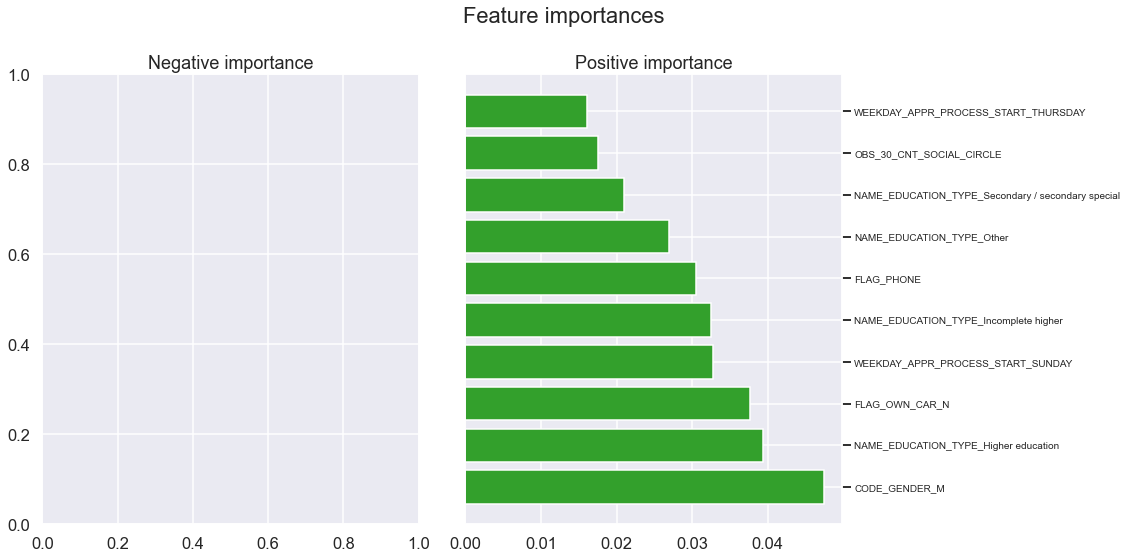

In [23]:
f_count = 10
feature_importances_plot(f_names, et.feature_importances_, f_count)

<div class="alert alert-block alert-info">
    
Contribution des variables.

</div>

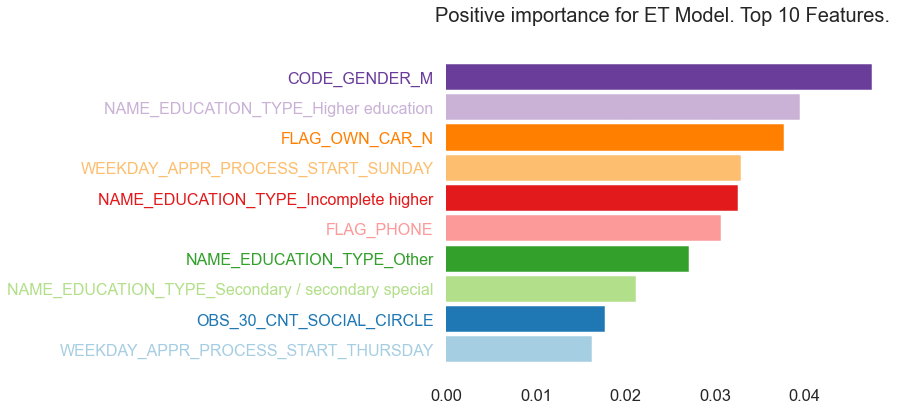

In [24]:
# Contribution les plus positives
fig = plt.figure(figsize=(8,6))
top_x = 10

indices = np.argsort(et.feature_importances_)           # Tri croissant
#indices = np.argsort(et.feature_importances_)[::-1]     # Tri décroissant 
indices = indices[-top_x:]

bars = plt.barh(range(len(indices)), et.feature_importances_[indices], color='b', align='center')
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
    bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Positive importance for ET Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

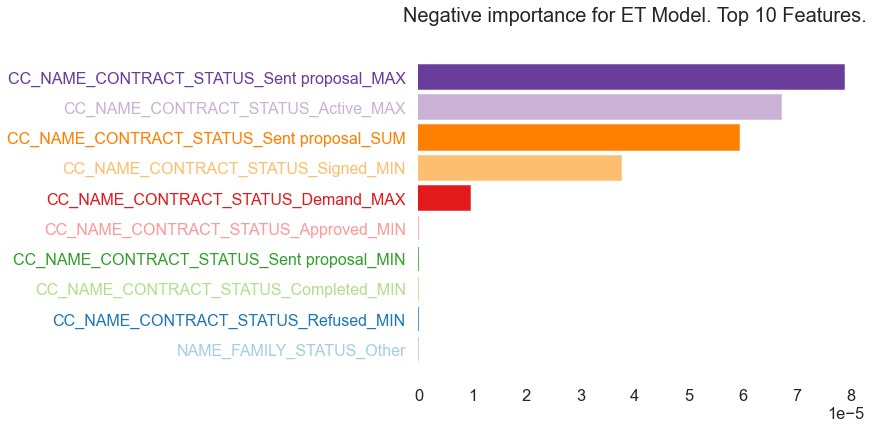

In [25]:
# Contribution les plus négatives
fig = plt.figure(figsize=(8,6))
top_x = 10

indices = np.argsort(et.feature_importances_)           # Tri croissant
#indices = np.argsort(et.feature_importances_)[::-1]     # Tri décroissant
indices = indices[:top_x]

bars = plt.barh(range(len(indices)), et.feature_importances_[indices], color='b', align='center') 
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
        bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Negative importance for ET Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

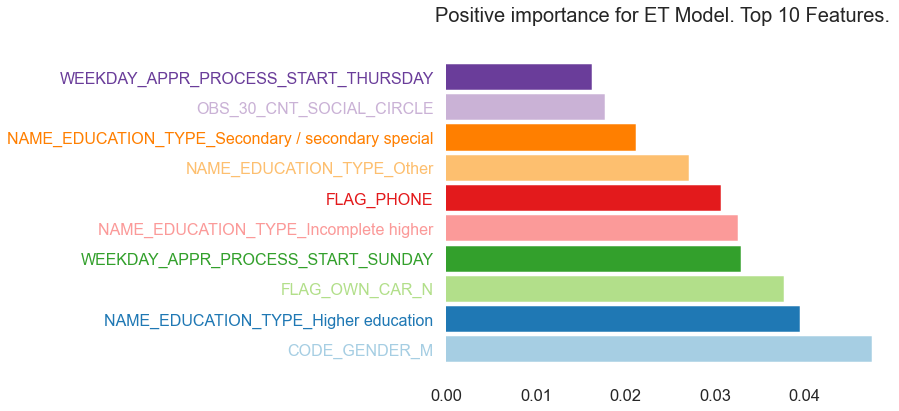

In [26]:
# Synthèse des variables les plus importantes
fig = plt.figure(figsize=(8,6))
top_x = 10

#indices = np.argsort(np.abs(et.feature_importances_))           # Tri croissant
indices = np.argsort(np.abs(et.feature_importances_))[::-1]     # Tri décroissant 
indices = indices[:top_x]

bars = plt.barh(range(len(indices)), np.abs(et.feature_importances_)[indices], color='b', align='center')
plt.yticks(range(len(indices)), [f_names[j] for j in indices], fontweight="normal", fontsize=16) 
for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
    ticklabel.set_color(palette[i]) 
for i,bar in enumerate(bars):
    bar.set_color(palette[i])
plt.box(False)
plt.suptitle("Positive importance for ET Model. Top " + str(top_x) + " Features.", fontsize=20, fontweight="normal");

<div class="alert alert-block alert-info">

##### 2.2.3.6 Sauvegarde des résultats des métriques de classification

</div>

In [27]:
# Jeux des données d'entraînement du fichier application 
res_metriques_classification = pd.read_csv('donnees/resultats/results_classification.csv', sep = ',', index_col = 0)

# Sauvegarde des "meilleurs" scores pour la classification 
if clas_scores_1['MDL_Test']['ROC-AUC'] >= clas_scores_2['MDL_Test']['ROC-AUC']:
    clas_scores_1.rename(columns={'MDL_Train':'ET_Train', 'MDL_Test':'ET_Test'}, inplace=True)
    res_metriques_classification = pd.concat([res_metriques_classification, clas_scores_1], axis=1)
else:
    clas_scores_2.rename(columns={'MDL_Train':'ET_Train', 'MDL_Test':'ET_Test'}, inplace=True)
    res_metriques_classification = pd.concat([res_metriques_classification, clas_scores_2], axis=1)
    
# Sauvegarde des "meilleurs" scores pour les métriques 
res_metriques_classification.to_csv("donnees/resultats/results_classification.csv", sep=',', index=True)